# Purpose

In this notebook we take spikes from **concatenated operant behaviour and open field sessions** and look at the grid cells. Note that the behaviour session (almost) always comes first so you need to offset the number of samples that are in the first (operant session) from the second one. This can be done in multiple ways including by just looking at the number of bytes in the first original binary file that openephys outputs

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn
import pandas as pd
import cv2
import sys
import re
from datetime import datetime as dt
import time
import scipy.ndimage as ndi 
#sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/yves/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
# Here we have copy pasted the size (in bytes) of the original operant behaviour sessions's ephys file and 
# used this size to calculate the offset, in samples, that has to be applied to the concatentated 
# operant+openField spike times in order to be aligned with the open field camera timestamps
n_bytes = 66257620992
samples_offset = (n_bytes/2/384)

In [5]:
from mecll.rsync import Rsync_aligner
from mecll.load import load_data

In [15]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path,align_to="OF")
spkT,spkC,single_units,events,lines,aligner = out

position = np.load(os.path.join(root_path,'OF_positions.npy'))

541 543


([<matplotlib.axis.XTick at 0x7f7992e83c10>,
 <a list of 10 Text xticklabel objects>)

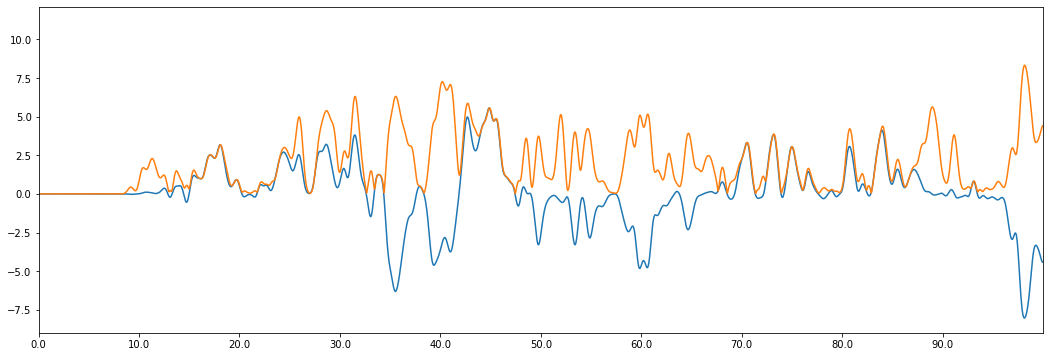

In [16]:
# calculate speed

plt.figure(figsize=(18,6))
delta_p = (position[1:] - position[:-1])
delta_p[np.logical_not(np.isfinite(delta_p[:,0])),:] = 0
delta_p[np.sum(np.abs(delta_p),axis=1)>20,:] = 0
#delta_p[np.sum(np.abs(delta_p),axis=1)<2,:] = 0

delta_p = ndi.gaussian_filter1d(delta_p,8,axis=0)
#delta_p[]
speed = np.concatenate([[0],np.sqrt(np.sum(delta_p**2,axis=1))])
plt.plot(delta_p[:,0])
plt.plot(speed)

#plt.plot(ndi.gaussian_filter1d(delta_p[:,0],7))

plt.xlim(0,3000)
plt.xticks(np.arange(0,3000,300),np.arange(0,3000,300)/30.)
#plt.ylim(-10,10)

In [18]:
import scipy as sp
import scipy.signal

In [22]:
import importlib

In [23]:
import mecll

In [24]:
mecll = importlib.reload(mecll.open_field_analysis.proc_grids)

In [25]:
# It is expected that running this should take some time.

all_rate_maps = []
for kk,unit in enumerate(single_units):
    sys.stdout.write('\rprocessing unit{}/{}'.format(kk,len(single_units)))
    sys.stdout.flush()
    
    # Key analysis function that runs a bunch of analyses from the Nolan lab to get 
    # spatial rate maps from the
    rate_map = mecll.get_rate_map_nolan(unit, aligner, 
                                        spkC, spkT,
                                        position,
                                        smooth=30
                                        )
    all_rate_maps.append(rate_map)
    

processing unit101/201

KeyboardInterrupt: 

In [26]:
# This then actually gives metrics
out = mecll.process_grid_data(all_rate_maps)

Not enough fields to calculate grid metrics.
Not enough fields to calculate grid metrics.


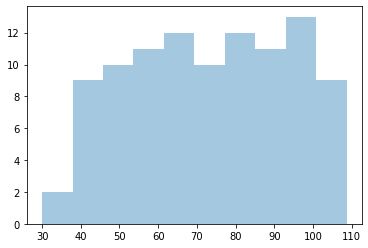

In [30]:
seaborn.distplot(np.array(out['grid_spacing'])[np.isfinite(out['grid_spacing'])],kde=0,bins=10)

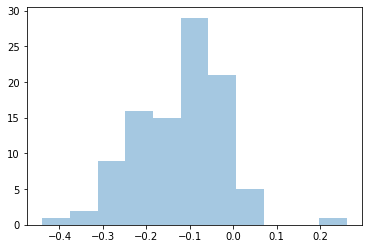

In [31]:
seaborn.distplot(np.array(out['grid_score'])[np.isfinite(out['grid_score'])],kde=0)

In [32]:
np.where(np.array(out['grid_score'])>0.2)[0]

array([75])

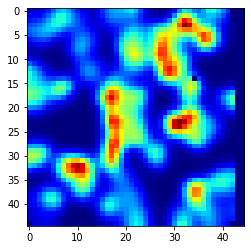

In [35]:
plt.imshow(all_rate_maps[75],cmap='jet')

In [36]:
plt.figure(figsize=(16,16))
kk = 1

n64 = 2

for ix in range(n64*144,(n64+1)*144):
    try:
        #unit_nr,resp_map,tot,mx = all_resp_arr[ix]
        resp_map = all_rate_maps[ix]
        plt.subplot(12,12,kk)
        plt.title('ix:{}'.format(ix))
        #plt.title('ix:{} | u:{} | cc:{}  \nn_spk:{} mx:{}'.format(ix,unit_nr,np.round(ccs[ix],decimals=2),tot,np.round(mx,decimals=1)))
        #resp_map = 
        #resp_map[np.isnan(resp_map)] = 0
        plt.imshow(resp_map,cmap='jet',interpolation='None')#,vmin=.0,vmax=.2)
        #plt.xlim(50,1050)
        #plt.ylim(50,1050)
        plt.xticks([])
        plt.yticks([])

        kk += 1
    except Exception as e:
        print(e)
        break
plt.tight_layout()

list index out of range


<Figure size 1152x1152 with 0 Axes>

In [37]:
len([ 36,  78,  84,  99, 113, 115, 116, 117, 132, 133, 140, 148,
       220, 258, 265, 270, 274, 275, 312])

19

IndexError: list index out of range

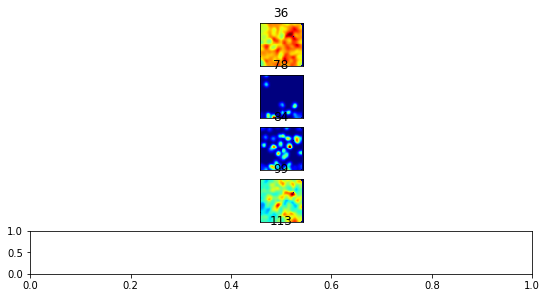

In [38]:
kk = 1
plt.figure(figsize=(9,18))
for i in [ 36,  78,  84,  99, 113, 115, 116, 117, 132, 133, 140, 148,
       265, 270, 274, 275, 312]:
    plt.subplot(19,1,kk)
    plt.title(i)
    plt.imshow(all_rate_maps[i],cmap='jet')
    kk+=1
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()